In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist['data'], mnist['target']

In [3]:
#Having a look at a digit by reshaping the image to a 28x28
import matplotlib as mpl
import matplotlib.pyplot as plt

In [4]:
X2 = X.to_numpy()

In [5]:
import numpy as np
import pandas as pd
some_digit = X2[0].reshape(28,28)
some_digit2 = X2[1].reshape(28,28)
tot = np.concatenate((some_digit,some_digit2),axis=1)

(-0.5, 55.5, 27.5, -0.5)

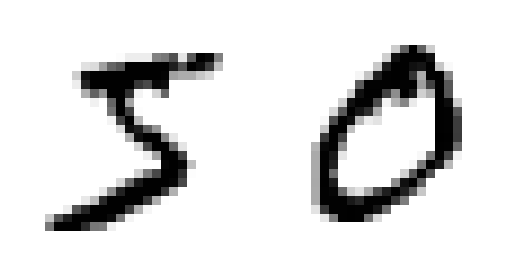

In [6]:
plt.imshow(tot, cmap='binary')
plt.axis('off')

In [7]:
print(y[0])

5


In [8]:
y = y.astype(int)

In [9]:
a1 = np.array([[1,2],[5,6]]); a2 = np.array([[3,4],[7,8]])
np.concatenate((a1,a2), axis=1)

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [10]:
#splitting between training and test sets
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [11]:
#Let's train a binary classifier for number 5
y_train_5 = y_train == 5
y_test_5 = y_test == 5

In [12]:
y_train_5

0         True
1        False
2        False
3        False
4        False
         ...  
59995    False
59996    False
59997     True
59998    False
59999    False
Name: class, Length: 60000, dtype: bool

In [13]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [14]:
sgd_clf.predict(X_train)

array([ True, False, False, ...,  True, False, False])

In [15]:
#Implementing a manual* Cross-Validation
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.metrics import accuracy_score
strat_kfold = StratifiedKFold(n_splits=3, shuffle= True, random_state=42)

for train_index, test_index in strat_kfold.split(X_train, y_train_5):
    X_train_fold = X_train.iloc[list(train_index)]
    y_train_fold = y_train_5.iloc[list(train_index)]
    X_test_fold = X_train.iloc[list(test_index)]
    y_test_fold = y_train_5.iloc[list(test_index)]
    sgd_clf.fit(X_train_fold, y_train_fold)
    y_hat = sgd_clf.predict(X_test_fold)
    print(accuracy_score(y_hat, y_test_fold))
    #print(sum(y_hat == y_test_fold)/y_hat.size)

0.9669
0.91625
0.96785


In [16]:
#Using Cross-Validation
from sklearn.model_selection import cross_val_score
cvs=cross_val_score(sgd_clf,X_train,y_train_5,cv=3)

In [17]:
print(cvs)

[0.95035 0.96035 0.9604 ]


##### The problem is that even a dummy classifier might perform well if there are not so many 5s

In [18]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, Y=None):
        return self
    def transform(self,X):
        return np.zeros(len(X), dtype = bool) #this is not necessary as it's the same of predict
    def predict(self,X):
        return np.zeros(len(X), dtype = bool)
    

In [19]:
trial = Never5Classifier()
cross_val_score(trial,X_train,y_train_5,cv=3,scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

In [20]:
#The confusion matrix is a way to deal with classification accuracy [[TN, FP], [FN, TP]]
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [21]:
y_train_pred.size

60000

In [22]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_pred,y_train_5)

array([[53892,  1891],
       [  687,  3530]], dtype=int64)

### The values in the confusion matrix one can obtain are Precision and Recall
#### Precision is TP/(TP + FP)
#### Recall is TP/(TP + FN)

In [23]:
from sklearn.metrics import recall_score, precision_score
print('Recall:', recall_score(y_train_pred,y_train_5))
print('Precision:', precision_score(y_train_pred,y_train_5))

Recall: 0.8370879772350012
Precision: 0.6511713705958311


In [24]:
#The harmonic mean of both values is called the F_1 score
from sklearn.metrics import f1_score
f1_score(y_train_pred,y_train_5)

0.7325171197343846

In [25]:
#Writing down the precision/recall trade off and the relation with the decision function
cvp_dec = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method='decision_function')

In [26]:
#setting a threshold value, taking into account that SGD will give positive if the decision_function value is > 0
thresh = 0.0
cvp_dec_predict_1 = cvp_dec > thresh
thresh_2 = 8000.
cvp_dec_predict_2 = cvp_dec > thresh_2

In [27]:
print(cvp_dec_predict_1)
print(cvp_dec_predict_2)

[ True False False ...  True False False]
[False False False ...  True False False]


In [28]:
#using now the precision recall curve
from sklearn.metrics import precision_recall_curve
precision,recall,threshold = precision_recall_curve(y_train_5,cvp_dec)

In [29]:
def plotPrecisionRecall(precision,recall,threshold):
    plt.plot(threshold,precision[:-1], 'b--')
    plt.plot(threshold,recall[:-1], 'r')

In [30]:
threshold.size == recall.size
print(threshold.size)
print(recall.size)

59966
59967


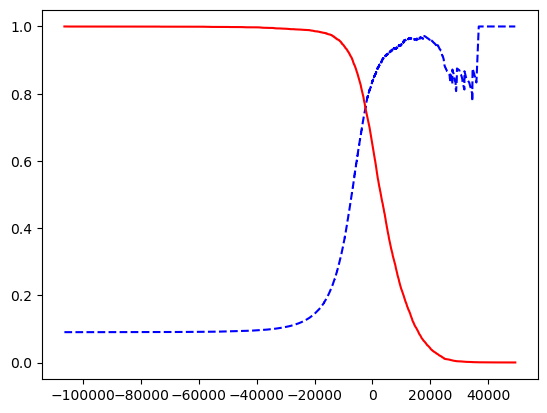

In [31]:
plotPrecisionRecall(precision,recall,threshold)

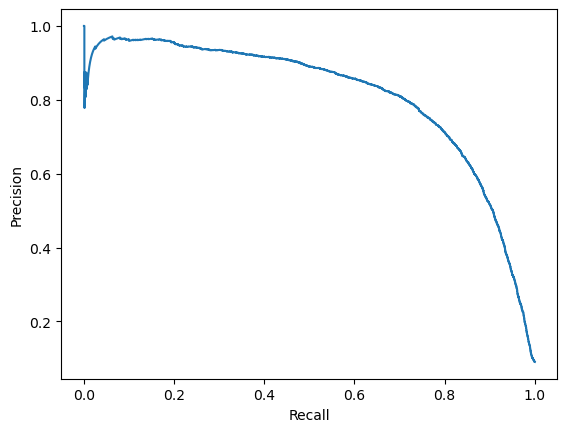

In [32]:
plt.figure()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(recall,precision)

In [37]:
#threshold where precision is at least 90%
threshold_90_precision = threshold[np.argmax(precision >= 0.9)]

In [38]:
y_train_pred_90 = cvp_dec > threshold_90_precision

In [39]:
precision_score(y_train_5,y_train_pred_90)

0.9

In [40]:
recall_score(y_train_5,y_train_pred_90)

0.47980077476480354

### The ROC curve

In [41]:
#This is the curve of recall against false positives (another trade-off for classification)
from sklearn.metrics import roc_curve

In [42]:
fpr,tpr,thresholds = roc_curve(y_train_5,cvp_dec)

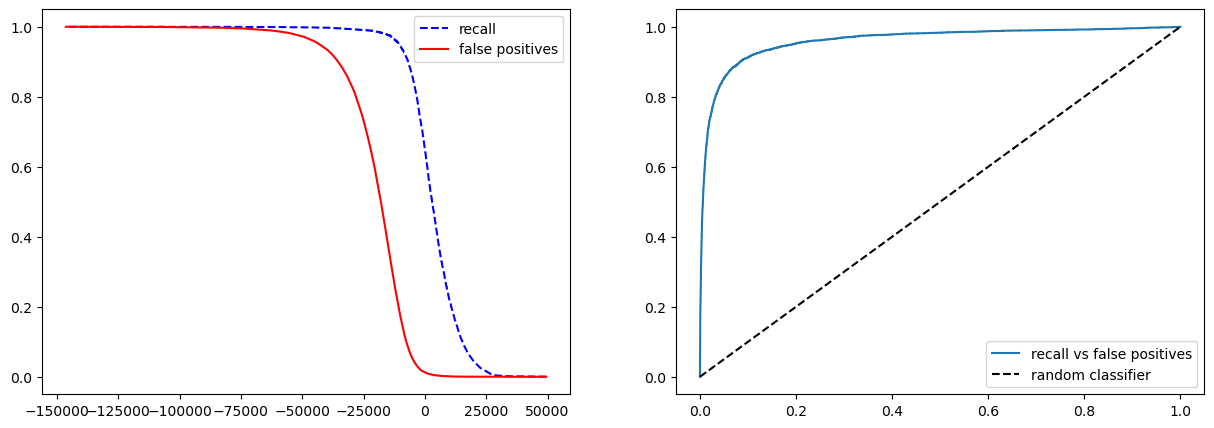

In [56]:
def plot_roc_curve(recall,false_positive,thresholds):  
    fig,ax = plt.subplots(1,2, figsize = (15,5))
    ax[0].plot(thresholds,recall, 'b--', label = 'recall')
    ax[0].plot(thresholds,false_positive, 'r-', label = 'false positives')
    ax[0].legend()
    ax[1].plot(false_positive, recall, label='recall vs false positives')
    ax[1].plot([0,1],[0,1],'k--', label = 'random classifier')
    ax[1].legend()
plot_roc_curve(tpr,fpr,thresholds)

In [57]:
#A good way to compute the quality of the roc curve is to compute its area below the blue curve
from sklearn.metrics import roc_auc_score

In [58]:
roc_score = roc_auc_score(y_train_5,cvp_dec)
roc_score

0.9604938554008616

In [60]:
#Let's train a Random forest
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=42)

In [62]:
rfc_scores = cross_val_predict(rfc,X_train,y_train_5,method='predict_proba',cv=3)

In [ ]:
rfc_predict = cross_val_predict(rfc,X_train,y_train_5,cv=3)

In [67]:
rfc_scores_positive = rfc_scores[:,1]

In [68]:
rfc_fpr,rfc_tpr,rfc_thresholds = roc_curve(y_train_5,rfc_scores_positive)

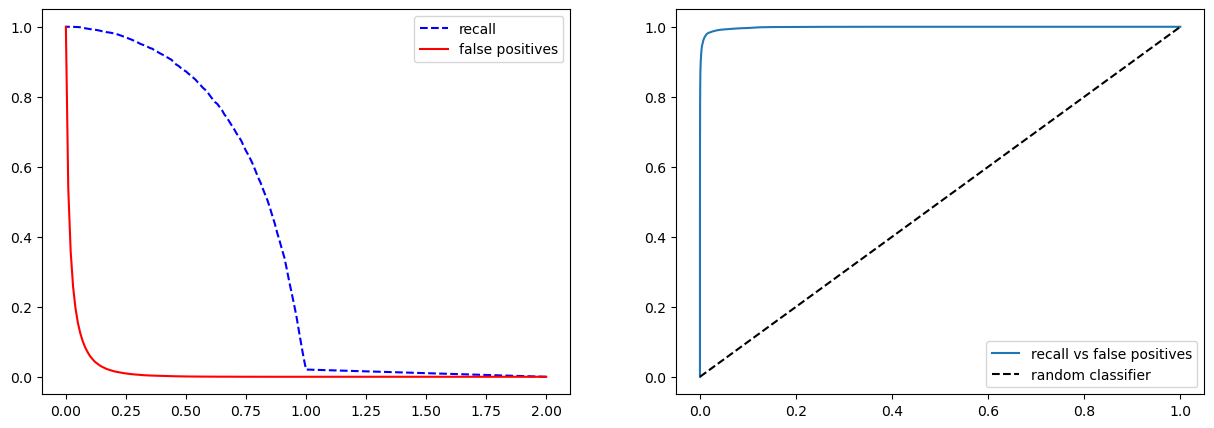

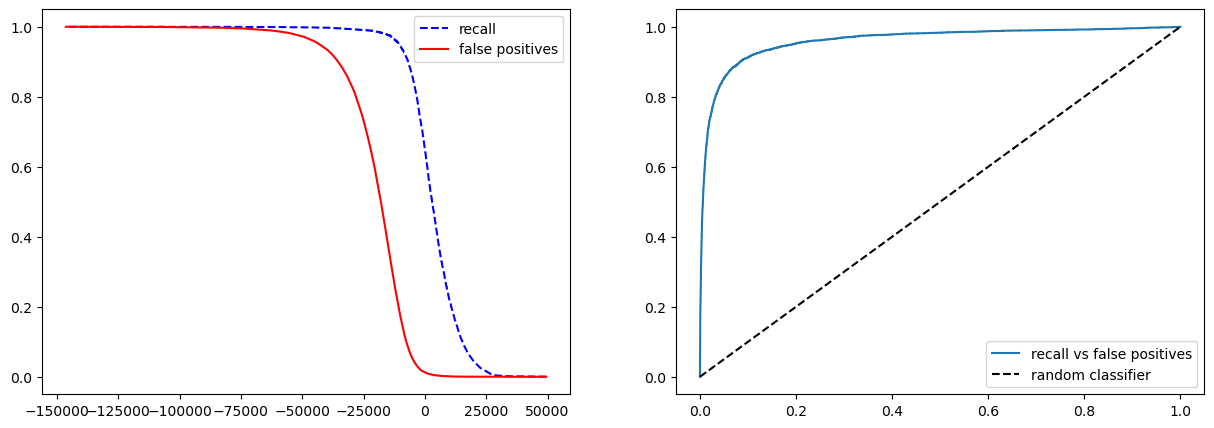

In [70]:
plot_roc_curve(rfc_tpr,rfc_fpr,rfc_thresholds)
plot_roc_curve(tpr,fpr,thresholds)

In [71]:
#Random forest performs quite better than the previous one SGD
roc_auc_score(y_train_5,rfc_scores_positive)

0.9983436731328145

In [73]:
recall_score(y_train_5,rfc_predict)

ValueError: Classification metrics can't handle a mix of binary and continuous-multioutput targets